In [1]:
# This code demonstrates how to fine-tune Vision Transformer (ViT) and SWIN models on the CIFAR-10 dataset and apply Grad-CAM visualization.

## 1. Setup Environment
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# !pip install torch torchvision timm pytorch-gradcam
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
#!pip show pytorch-gradcam
#!ls /usr/local/lib/python3.11/dist-packages/

In [2]:
## 2. Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

## 3. Data Preparation

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]
    )


c:\Users\user\Miniconda3\envs\rnn_transformer_hw4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
classes_name = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
from torch.utils.data import DataLoader, SubsetRandomSampler
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# 分割訓練集和驗證集
validation_split = 0.2
dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

# 隨機打亂索引
np.random.seed(42)  # 為了可重複性設置隨機種子
np.random.shuffle(indices)

# 分割索引為訓練和驗證部分
train_indices, val_indices = indices[split:], indices[:split]

# 創建採樣器
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# 準備數據加載器
trainloader = DataLoader(
    trainset, 
    batch_size=128, 
    sampler=train_sampler,
    num_workers=2
)

valloader = DataLoader(
    trainset,  # 注意這裡仍然使用原始訓練集
    batch_size=128, 
    sampler=val_sampler,
    num_workers=2
)

testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training set size: {len(train_indices)}")
print(f"Validation set size: {len(val_indices)}")
print(f"Test set size: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [5]:
# 檢查數據預處理是否有問題
def check_data_preprocessing():
    print("=== 檢查數據預處理 ===")
    
    # 檢查原始 CIFAR-10 圖像
    original_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
    original_image, original_label = original_testset[0]
    
    print(f"原始圖像大小: {original_image.size}")
    print(f"原始圖像類型: {type(original_image)}")
    print(f"原始標籤: {original_label}")
    
    # 檢查變換後的圖像
    transformed_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    transformed_image, transformed_label = transformed_testset[0]
    
    print(f"變換後圖像形狀: {transformed_image.shape}")
    print(f"變換後圖像範圍: {transformed_image.min():.4f} ~ {transformed_image.max():.4f}")
    print(f"變換後標籤: {transformed_label}")
    
    # 檢查變換是否正確
    print(f"標籤是否一致: {original_label == transformed_label}")
    
    return original_image, transformed_image

original_img, transformed_img = check_data_preprocessing()

=== 檢查數據預處理 ===
Files already downloaded and verified
原始圖像大小: (32, 32)
原始圖像類型: <class 'PIL.Image.Image'>
原始標籤: 3
Files already downloaded and verified
變換後圖像形狀: torch.Size([3, 224, 224])
變換後圖像範圍: -1.7831 ~ 2.0943
變換後標籤: 3
標籤是否一致: True


In [6]:
## 4. Improved Model Setup

# Load pre-trained models
vit_model = timm.create_model('vit_large_patch16_224', pretrained=True)
swin_model = timm.create_model('swin_large_patch4_window7_224.ms_in22k_ft_in1k', pretrained=True)

# Move models to device first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)
swin_model.to(device)

# 檢查原始分類頭的結構
print("Original ViT head:", vit_model.head)
print("Original SWIN head:", swin_model.head)

# 檢查特徵維度
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    
    # ViT 特徵檢查
    vit_features = vit_model.forward_features(dummy_input)
    print(f"ViT features shape: {vit_features.shape}")
    
    # SWIN 特徵檢查
    swin_features = swin_model.forward_features(dummy_input)
    print(f"SWIN features shape: {swin_features.shape}")

# 修改分類頭 - 使用更簡單的策略
print(f"ViT head input features: {vit_model.head.in_features}")
print(f"SWIN head input features: {swin_model.head.fc.in_features}")

# ViT: 簡單替換
vit_model.head = nn.Linear(vit_model.head.in_features, 10)

# SWIN: 保持原始結構，只修改最後的分類層
swin_model.head.fc = nn.Linear(swin_model.head.fc.in_features, 10)

def corrected_freeze_strategy(model, model_type='vit'):
    """修正的凍結策略，讓兩個模型有更合理的可訓練參數"""
    
    if model_type == 'vit':
        # ViT: 只訓練最後 2-3 層 + 分類頭
        for name, param in model.named_parameters():
            if ('head' in name or 
                'blocks.11' in name or 
                'blocks.10' in name):
                param.requires_grad = True
                print(f"ViT Training: {name}")
            else:
                param.requires_grad = False
                
    elif model_type == 'swin':
        # SWIN: 只訓練分類頭和最後一個 stage 的部分層
        for name, param in model.named_parameters():
            if ('head.fc' in name or  # 只訓練分類頭的 fc 層
                'layers.3.blocks.1' in name or  # 最後一個 block
                'norm.weight' in name or  # 最終的 norm 層（不是所有 norm）
                'norm.bias' in name):
                param.requires_grad = True
                print(f"SWIN Training: {name}")
            else:
                param.requires_grad = False

# 重新應用修正的凍結策略
print("\n=== Applying Corrected Freezing Strategy ===")

# 首先重置所有參數為可訓練
for param in vit_model.parameters():
    param.requires_grad = True
for param in swin_model.parameters():
    param.requires_grad = True

# 然後應用新的凍結策略
corrected_freeze_strategy(vit_model, 'vit')
corrected_freeze_strategy(swin_model, 'swin')


# 檢查可訓練參數
def count_parameters(model, model_name):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name}:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Frozen parameters: {total_params - trainable_params:,}")
    print(f"  Trainable ratio: {trainable_params/total_params*100:.2f}%")
    return trainable_params

# 檢查修正後的參數統計
print("\n=== Corrected Parameter Statistics ===")
vit_trainable = count_parameters(vit_model, "ViT")
swin_trainable = count_parameters(swin_model, "SWIN")

# Move models back to device after modifications
vit_model.to(device)
swin_model.to(device)

c:\Users\user\Miniconda3\envs\rnn_transformer_hw4\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--timm--swin_large_patch4_window7_224.ms_in22k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Original ViT head: Linear(in_features=1024, out_features=1000, bias=True)
Original SWIN head: ClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Identity())
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=1536, out_features=1000, bias=True)
  (flatten): Identity()
)
ViT features shape: torch.Size([1, 197, 1024])
SWIN features shape: torch.Size([1, 7, 7, 1536])
ViT head input features: 1024
SWIN head input features: 1536

=== Applying Corrected Freezing Strategy ===
ViT Training: blocks.10.norm1.weight
ViT Training: blocks.10.norm1.bias
ViT Training: blocks.10.attn.qkv.weight
ViT Training: blocks.10.attn.qkv.bias
ViT Training: blocks.10.attn.proj.weight
ViT Training: blocks.10.attn.proj.bias
ViT Training: blocks.10.norm2.weight
ViT Training: blocks.10.norm2.bias
ViT Training: blocks.10.mlp.fc1.weight
ViT Training: blocks.10.mlp.fc1.bias
ViT Training: blocks.10.mlp.fc2.weight
ViT Training: blocks.10.mlp.fc2.bias
ViT Training: blocks.11.norm1.w

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
            (

In [ ]:
## 7. Evaluation

def evaluate_model(model, dataloader, criterion=None, return_loss=False):
    
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 確保標籤格式正確
            if labels.dim() > 1:
                labels = labels.squeeze()
            if labels.dim() == 0:
                labels = labels.unsqueeze(0)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 計算損失
            if criterion is not None:
                loss = criterion(outputs, labels.long())
                running_loss += loss.item()
    
    accuracy = 100 * correct / total
    
    if return_loss and criterion is not None:
        avg_loss = running_loss / len(dataloader)
        return avg_loss, accuracy
    else:
        return accuracy

In [13]:
from tqdm import tqdm
def train_model_improved(model, trainloader, valloader, criterion, optimizer, scheduler, 
                        num_epochs=30, model_name="model", patience=7):
    """
    改進的訓練函數 - 更適合 fine-tuning
    """
    print(f"\n=== 開始訓練 {model_name.upper()} ===")
    
    # 歷史記錄
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'learning_rates': []
    }
    
    best_val_accuracy = 0.0
    patience_counter = 0
    
    # 訓練前評估
    print("訓練前評估...")
    initial_val_acc = evaluate_model(model, valloader)
    print(f"初始驗證準確率: {initial_val_acc:.2f}%")
    
    for epoch in range(num_epochs):
        # === 訓練階段 ===
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 記錄學習率
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        
        # 進度條
        progress_bar = tqdm(trainloader, 
                           desc=f'{model_name.upper()} Epoch {epoch+1}/{num_epochs}',
                           leave=False)
        
        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 確保標籤格式正確
            if labels.dim() > 1:
                labels = labels.squeeze()
            if labels.dim() == 0:
                labels = labels.unsqueeze(0)
            
            # 前向傳播
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            
            # 反向傳播
            loss.backward()
            
            # 梯度裁剪（防止梯度爆炸）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # 統計
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 更新進度條
            if batch_idx % 10 == 0:  # 每10個batch更新一次
                current_acc = 100 * correct / total
                progress_bar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{current_acc:.2f}%',
                    'LR': f'{current_lr:.6f}'
                })
        
        # === 計算訓練指標 ===
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)
        
        # === 驗證階段 ===
        val_loss, val_accuracy = evaluate_model(model, valloader, criterion, return_loss=True)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        # === 打印結果 ===
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
        print(f'  Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')
        
        # === 保存最佳模型 ===
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_val_accuracy': best_val_accuracy,
                'history': history
            }, f'{model_name}_best.pth')
            print(f'  保存最佳模型! 驗證準確率: {val_accuracy:.2f}% (提升 {val_accuracy-best_val_accuracy:.2f}%)')
        else:
            patience_counter += 1
            print(f'  無改善. 耐心計數: {patience_counter}/{patience}')
            
            if patience_counter >= patience:
                print(f"  Early stopping 觸發 (連續 {patience} epochs 無改善)")
                break
        
        # === 更新學習率 ===
        if scheduler is not None:
            scheduler.step()
        
        print("-" * 50)
    
    # 載入最佳模型
    if best_val_accuracy > 0:
        print(f"\n 載入最佳模型 (驗證準確率: {best_val_accuracy:.2f}%)")
        checkpoint = torch.load(f'{model_name}_best.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f" {model_name.upper()} 訓練完成!")
    print(f"   最佳驗證準確率: {best_val_accuracy:.2f}%")
    print(f"   改善幅度: {best_val_accuracy - initial_val_acc:.2f}%")
    
    return model, history

In [14]:
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR


print("=== Fine-tuning 設置 ===")

# 1. 檢查當前可訓練參數
def count_trainable_parameters(model, model_name):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name}:")
    print(f"  總參數: {total_params:,}")
    print(f"  可訓練參數: {trainable_params:,}")
    print(f"  可訓練比例: {trainable_params/total_params*100:.2f}%")
    return trainable_params

vit_trainable = count_trainable_parameters(vit_model, "ViT")
swin_trainable = count_trainable_parameters(swin_model, "Swin")

# 2. 定義損失函數
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing 有助於泛化
print(" 使用 CrossEntropyLoss with label smoothing")

# 3. 優化器設置 - 根據可訓練參數調整學習率
# 更保守的學習率，適合 fine-tuning
vit_lr = 5e-4 if vit_trainable > 10_000_000 else 1e-3  # 大模型用較小學習率
swin_lr = 5e-4 if swin_trainable > 10_000_000 else 1e-3

vit_optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, vit_model.parameters()), 
    lr=vit_lr, 
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

swin_optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, swin_model.parameters()), 
    lr=swin_lr,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

print(f"ViT 學習率: {vit_lr}")
print(f"Swin 學習率: {swin_lr}")

# 4. 學習率調度器 - 使用更溫和的調度
vit_scheduler = CosineAnnealingLR(vit_optimizer, T_max=30, eta_min=1e-6)
swin_scheduler = CosineAnnealingLR(swin_optimizer, T_max=30, eta_min=1e-6)

=== Fine-tuning 設置 ===
ViT:
  總參數: 303,311,882
  可訓練參數: 25,202,698
  可訓練比例: 8.31%
Swin:
  總參數: 195,010,846
  可訓練參數: 28,369,210
  可訓練比例: 14.55%
 使用 CrossEntropyLoss with label smoothing
ViT 學習率: 0.0005
Swin 學習率: 0.0005


In [15]:
def plot_training_history(vit_history, swin_history):
    """
    可視化訓練歷史
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 損失曲線
    axes[0, 0].plot(vit_history['train_loss'], label='ViT Train', color='blue')
    axes[0, 0].plot(vit_history['val_loss'], label='ViT Val', color='lightblue')
    axes[0, 0].plot(swin_history['train_loss'], label='Swin Train', color='red')
    axes[0, 0].plot(swin_history['val_loss'], label='Swin Val', color='lightcoral')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # 準確率曲線
    axes[0, 1].plot(vit_history['train_accuracy'], label='ViT Train', color='blue')
    axes[0, 1].plot(vit_history['val_accuracy'], label='ViT Val', color='lightblue')
    axes[0, 1].plot(swin_history['train_accuracy'], label='Swin Train', color='red')
    axes[0, 1].plot(swin_history['val_accuracy'], label='Swin Val', color='lightcoral')
    axes[0, 1].set_title('Training & Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # 學習率曲線
    axes[1, 0].plot(vit_history['learning_rates'], label='ViT LR', color='blue')
    axes[1, 0].plot(swin_history['learning_rates'], label='Swin LR', color='red')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # 驗證準確率對比
    axes[1, 1].plot(vit_history['val_accuracy'], label='ViT', color='blue', linewidth=2)
    axes[1, 1].plot(swin_history['val_accuracy'], label='Swin', color='red', linewidth=2)
    axes[1, 1].set_title('Validation Accuracy Comparison')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [16]:
vit_model.to(device)
swin_model.to(device)

print(" 開始 Fine-tuning...")
print(f" 訓練集大小: {len(trainloader)} batches")
print(f" 驗證集大小: {len(valloader)} batches")
print(f" 設備: {device}")

 開始 Fine-tuning...
 訓練集大小: 313 batches
 驗證集大小: 79 batches
 設備: cuda


In [17]:
# 訓練 ViT
print("\n" + "="*60)
vit_model, vit_history = train_model_improved(
    vit_model, trainloader, valloader, criterion, 
    vit_optimizer, vit_scheduler, 
    num_epochs=30, model_name="vit", patience=7
)



=== 開始訓練 VIT ===
訓練前評估...
初始驗證準確率: 17.47%



Epoch 1/30:
  Train - Loss: 0.6186, Accuracy: 96.48%
  Val   - Loss: 0.5534, Accuracy: 98.55%
  Learning Rate: 0.000500
  保存最佳模型! 驗證準確率: 98.55% (提升 0.00%)
--------------------------------------------------



Epoch 2/30:
  Train - Loss: 0.5319, Accuracy: 99.23%
  Val   - Loss: 0.5543, Accuracy: 98.22%
  Learning Rate: 0.000499
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 3/30:
  Train - Loss: 0.5218, Accuracy: 99.52%
  Val   - Loss: 0.5632, Accuracy: 97.58%
  Learning Rate: 0.000495
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 4/30:
  Train - Loss: 0.5162, Accuracy: 99.68%
  Val   - Loss: 0.5430, Accuracy: 98.50%
  Learning Rate: 0.000488
  無改善. 耐心計數: 3/7
--------------------------------------------------



Epoch 5/30:
  Train - Loss: 0.5137, Accuracy: 99.72%
  Val   - Loss: 0.5488, Accuracy: 98.29%
  Learning Rate: 0.000478
  無改善. 耐心計數: 4/7
--------------------------------------------------



Epoch 6/30:
  Train - Loss: 0.5116, Accuracy: 99.75%
  Val   - Loss: 0.5508, Accuracy: 97.93%
  Learning Rate: 0.000467
  無改善. 耐心計數: 5/7
--------------------------------------------------



Epoch 7/30:
  Train - Loss: 0.5099, Accuracy: 99.79%
  Val   - Loss: 0.5416, Accuracy: 98.43%
  Learning Rate: 0.000452
  無改善. 耐心計數: 6/7
--------------------------------------------------



Epoch 8/30:
  Train - Loss: 0.5077, Accuracy: 99.84%
  Val   - Loss: 0.5447, Accuracy: 98.20%
  Learning Rate: 0.000436
  無改善. 耐心計數: 7/7
  Early stopping 觸發 (連續 7 epochs 無改善)

 載入最佳模型 (驗證準確率: 98.55%)


C:\Users\user\AppData\Local\Temp\ipykernel_18176\1623905071.py:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{model_name}_best.pth')


 VIT 訓練完成!
   最佳驗證準確率: 98.55%
   改善幅度: 81.08%


In [ ]:
print("\n" + "="*60)
swin_model, swin_history = train_model_improved(
    swin_model, trainloader, valloader, criterion,
    swin_optimizer, swin_scheduler, 
    num_epochs=19, model_name="swin", patience=7
)



=== 開始訓練 SWIN ===
訓練前評估...
初始驗證準確率: 15.24%



Epoch 1/30:
  Train - Loss: 0.5899, Accuracy: 97.53%
  Val   - Loss: 0.5367, Accuracy: 98.84%
  Learning Rate: 0.000500
  保存最佳模型! 驗證準確率: 98.84% (提升 0.00%)
--------------------------------------------------



Epoch 2/30:
  Train - Loss: 0.5324, Accuracy: 99.08%
  Val   - Loss: 0.5350, Accuracy: 98.77%
  Learning Rate: 0.000499
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 3/30:
  Train - Loss: 0.5216, Accuracy: 99.43%
  Val   - Loss: 0.5346, Accuracy: 98.87%
  Learning Rate: 0.000495
  保存最佳模型! 驗證準確率: 98.87% (提升 0.00%)
--------------------------------------------------



Epoch 4/30:
  Train - Loss: 0.5158, Accuracy: 99.59%
  Val   - Loss: 0.5323, Accuracy: 98.86%
  Learning Rate: 0.000488
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 5/30:
  Train - Loss: 0.5125, Accuracy: 99.71%
  Val   - Loss: 0.5330, Accuracy: 98.75%
  Learning Rate: 0.000478
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 6/30:
  Train - Loss: 0.5108, Accuracy: 99.79%
  Val   - Loss: 0.5324, Accuracy: 98.95%
  Learning Rate: 0.000467
  保存最佳模型! 驗證準確率: 98.95% (提升 0.00%)
--------------------------------------------------



Epoch 7/30:
  Train - Loss: 0.5101, Accuracy: 99.80%
  Val   - Loss: 0.5326, Accuracy: 98.86%
  Learning Rate: 0.000452
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 8/30:
  Train - Loss: 0.5087, Accuracy: 99.83%
  Val   - Loss: 0.5296, Accuracy: 98.88%
  Learning Rate: 0.000436
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 9/30:
  Train - Loss: 0.5070, Accuracy: 99.86%
  Val   - Loss: 0.5332, Accuracy: 98.82%
  Learning Rate: 0.000417
  無改善. 耐心計數: 3/7
--------------------------------------------------



Epoch 10/30:
  Train - Loss: 0.5063, Accuracy: 99.88%
  Val   - Loss: 0.5303, Accuracy: 98.86%
  Learning Rate: 0.000397
  無改善. 耐心計數: 4/7
--------------------------------------------------



Epoch 11/30:
  Train - Loss: 0.5059, Accuracy: 99.91%
  Val   - Loss: 0.5294, Accuracy: 98.95%
  Learning Rate: 0.000375
  無改善. 耐心計數: 5/7
--------------------------------------------------



Epoch 12/30:
  Train - Loss: 0.5050, Accuracy: 99.92%
  Val   - Loss: 0.5302, Accuracy: 98.95%
  Learning Rate: 0.000352
  無改善. 耐心計數: 6/7
--------------------------------------------------



Epoch 13/30:
  Train - Loss: 0.5047, Accuracy: 99.94%
  Val   - Loss: 0.5300, Accuracy: 98.97%
  Learning Rate: 0.000328
  保存最佳模型! 驗證準確率: 98.97% (提升 0.00%)
--------------------------------------------------



Epoch 14/30:
  Train - Loss: 0.5049, Accuracy: 99.92%
  Val   - Loss: 0.5319, Accuracy: 98.88%
  Learning Rate: 0.000302
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 15/30:
  Train - Loss: 0.5046, Accuracy: 99.92%
  Val   - Loss: 0.5328, Accuracy: 98.86%
  Learning Rate: 0.000277
  無改善. 耐心計數: 2/7
--------------------------------------------------



Epoch 16/30:
  Train - Loss: 0.5043, Accuracy: 99.95%
  Val   - Loss: 0.5287, Accuracy: 98.99%
  Learning Rate: 0.000251
  保存最佳模型! 驗證準確率: 98.99% (提升 0.00%)
--------------------------------------------------



Epoch 17/30:
  Train - Loss: 0.5038, Accuracy: 99.95%
  Val   - Loss: 0.5314, Accuracy: 98.89%
  Learning Rate: 0.000224
  無改善. 耐心計數: 1/7
--------------------------------------------------



Epoch 18/30:
  Train - Loss: 0.5036, Accuracy: 99.95%
  Val   - Loss: 0.5284, Accuracy: 99.01%
  Learning Rate: 0.000199
  保存最佳模型! 驗證準確率: 99.01% (提升 0.00%)
--------------------------------------------------


SWIN Epoch 19/30:  88%|████████▊ | 277/313 [45:59<05:49,  9.71s/it, Loss=0.5039, Acc=99.93%, LR=0.000173]

In [ ]:
print("\n" + "="*60)
print(" 最終測試集評估...")

vit_test_accuracy = evaluate_model(vit_model, testloader)
swin_test_accuracy = evaluate_model(swin_model, testloader)

print(f"   ViT 測試準確率:  {vit_test_accuracy:.2f}%")
print(f"   Swin 測試準確率: {swin_test_accuracy:.2f}%")


 最終測試集評估...
   ViT 測試準確率:  88.94%
   Swin 測試準確率: 97.06%


In [2]:
import timm
import torch
import torch.nn as nn

# 設定裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 載入 ViT 與 Swin 模型，並修改分類頭為 10 類
vit_model = timm.create_model('vit_large_patch16_224', pretrained=False)
vit_model.head = nn.Linear(vit_model.head.in_features, 10)
vit_model.load_state_dict(torch.load('vit_best.pth', map_location=device)['model_state_dict'])
vit_model.to(device).eval()

swin_model = timm.create_model('swin_large_patch4_window7_224.ms_in22k_ft_in1k', pretrained=False)
swin_model.head.fc = nn.Linear(swin_model.head.fc.in_features, 10)
swin_model.load_state_dict(torch.load('swin_best.pth', map_location=device)['model_state_dict'])
swin_model.to(device).eval()

c:\Users\user\Miniconda3\envs\rnn_transformer_hw4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\AppData\Local\Temp\ipykernel_34328\4022135003.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
            (

In [5]:
import torchvision.transforms as transforms
import torchvision

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)

dataiter = iter(testloader)
images, labels = next(dataiter)
image_batch = [images[i] for i in range(10)]
label_batch = [labels[i].item() for i in range(10)]


Files already downloaded and verified


In [6]:
from scipy.ndimage import zoom

class GradCAM:
    def __init__(self, model, target_layers, reshape_transform=None):
        self.model = model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.activations = []
        self.gradients = []
        self.handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations.append(output[0] if isinstance(output, tuple) else output)

        def backward_hook(module, grad_input, grad_output):
            self.gradients.append(grad_output[0] if isinstance(grad_output, tuple) else grad_output)

        for layer in self.target_layers:
            self.handles.append(layer.register_forward_hook(forward_hook))
            self.handles.append(layer.register_full_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()

    def __call__(self, input_tensor, target_category=None):
        self.activations, self.gradients = [], []
        input_tensor.requires_grad_(True)
        output = self.model(input_tensor)
        if target_category is None:
            target_category = torch.argmax(output, dim=1)
        self.model.zero_grad()
        target = output[0, target_category[0]]
        target.backward(retain_graph=True)
        activations = self.reshape_transform(self.activations[-1])
        gradients = self.reshape_transform(self.gradients[-1])
        weights = gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * activations).sum(dim=1)).squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam
def reshape_transform_vit(tensor):
    tensor = tensor[:, 1:, :]
    B, N, C = tensor.shape
    H = W = int(N ** 0.5)
    tensor = tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
    return tensor

def reshape_transform_swin(tensor):
    if tensor.dim() == 3:
        B, N, C = tensor.shape
        H = W = int(N ** 0.5)
        tensor = tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
    elif tensor.dim() == 4:
        tensor = tensor.permute(0, 3, 1, 2)
    return tensor

def show_cam_on_image(img_tensor, cam_mask):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    cam_mask = zoom(cam_mask, (img.shape[0] / cam_mask.shape[0], img.shape[1] / cam_mask.shape[1]))
    heatmap = plt.cm.jet(cam_mask)[:, :, :3]
    return np.clip(heatmap * 0.5 + img * 0.5, 0, 1)



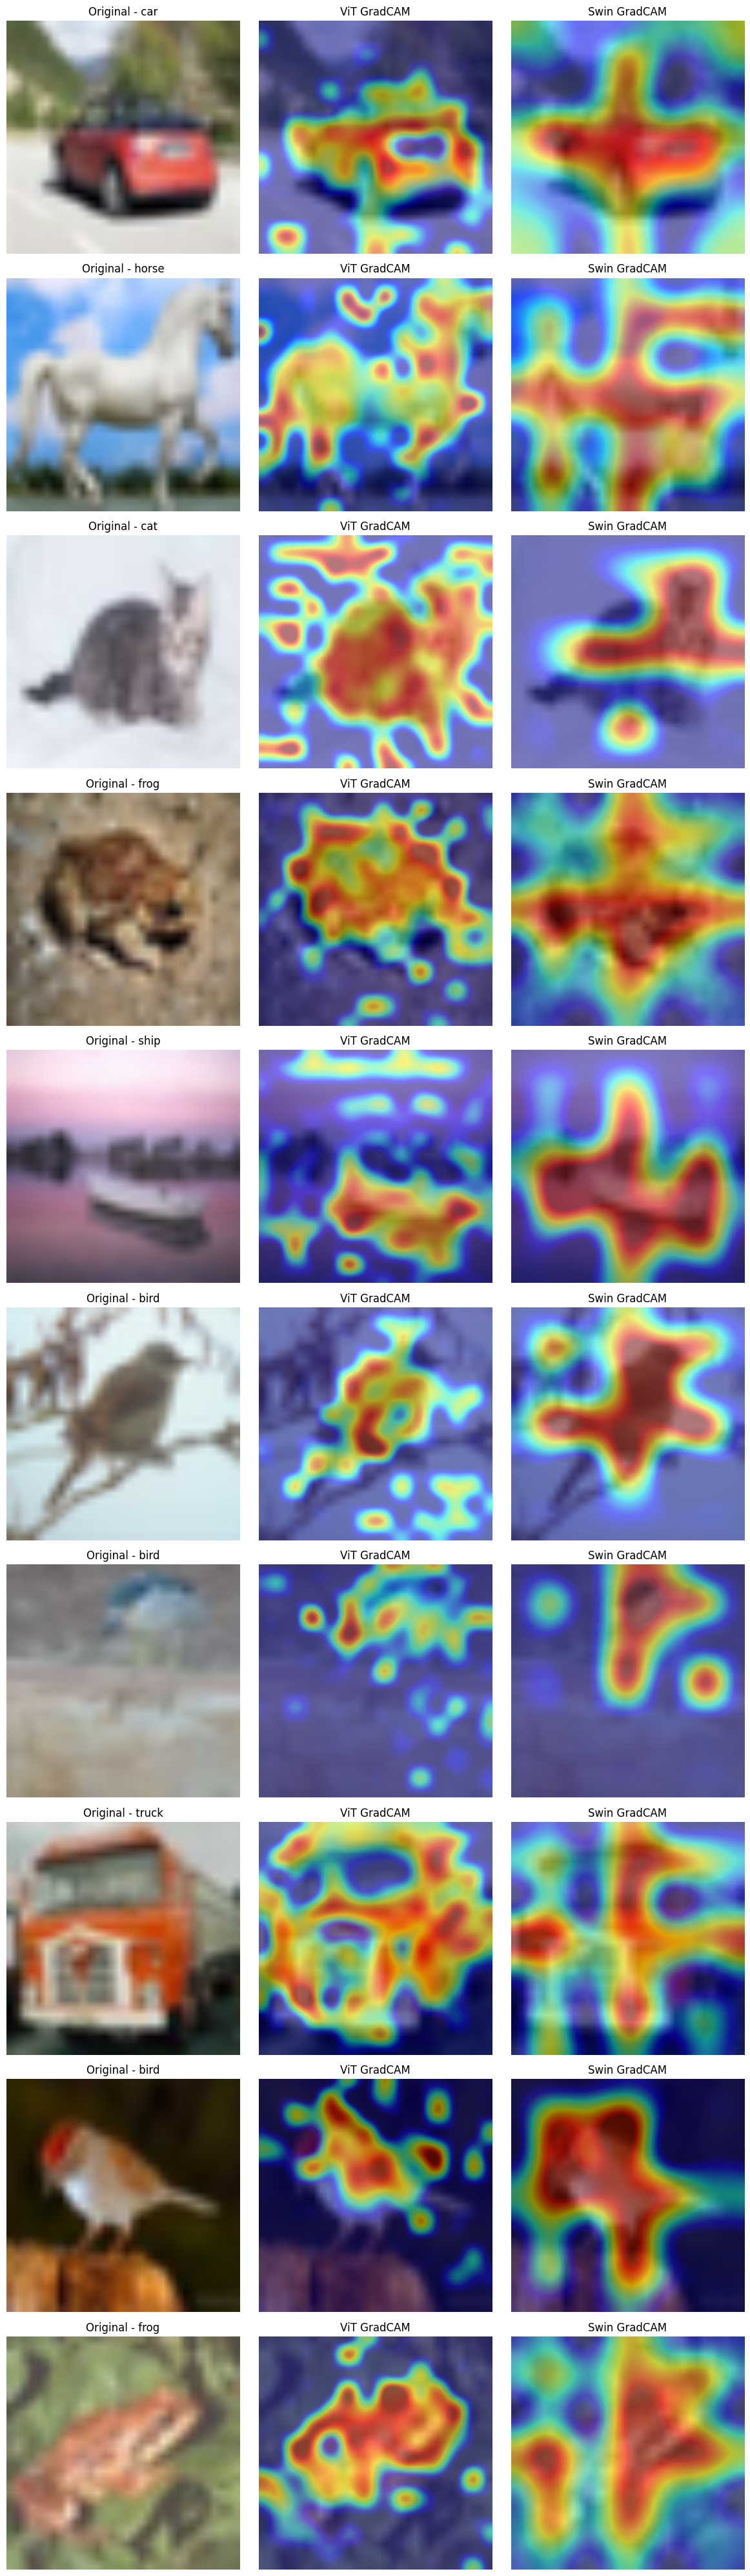

In [8]:
import matplotlib.pyplot as plt
import numpy as np
classes_name = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')



fig, axes = plt.subplots(len(image_batch), 3, figsize=(12, 4 * len(image_batch)))
for i, img in enumerate(image_batch):
    img_input = img.unsqueeze(0).to(device)
    # ViT GradCAM
    vit_cam = GradCAM(vit_model, [vit_model.blocks[-1].norm1], reshape_transform_vit)
    vit_result = vit_cam(img_input)
    vit_cam.remove_hooks()
    # Swin GradCAM
    swin_cam = GradCAM(swin_model, [swin_model.layers[-1].blocks[-1].attn], reshape_transform_swin)
    swin_result = swin_cam(img_input)
    swin_cam.remove_hooks()
    # Plotting

    # let original image not blue
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)
    axes[i][0].imshow(img_np)

    axes[i][0].set_title(f"Original - {classes_name[label_batch[i]]}")
    axes[i][1].imshow(show_cam_on_image(img, vit_result))
    axes[i][1].set_title(f"ViT GradCAM")
    axes[i][2].imshow(show_cam_on_image(img, swin_result))
    axes[i][2].set_title(f"Swin GradCAM")
    for j in range(3):
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()
